## MAP

Inspired by pair trading. For a thorough explanation refer to: https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_Pairs_Trading/notebook.ipynb

The idea is to use 2 time series that should maintain some relationship over time. If this pair diverges from some expected relationship at any point in time then an exception is flagged.

In regards to MAP we compare each [site, article, uom] MAP against the overall [salesorgs, article, uom] MAP. Once the spread divergenes significantly from recent history an exception is flagged.

We also propose a dollar impact cut-off to avoid flagging too many immaterial divergences.

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# mount drive
from google.colab import drive
drive.mount('/content/drive')


Authenticated
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
!pip install dfply
from dfply import *

from google.cloud import bigquery
import pandas_gbq
import pandas as pd
import numpy as np
import sys
import os
import plotnine as p9
from mizani.formatters import currency_format
import matplotlib.pyplot as plt

# define functions

In [76]:
def run_bq(sql, client, location="US"):
    query_job = client.query(sql, location=location)
    # wait for query to run_bq
    query_job.result()

def get_bq_data(sql, project_id):
    import pandas_gbq
    return pandas_gbq.read_gbq(sql,
                               project_id=project_id,
                               use_bqstorage_api=True)

def gridPlot_(df, dollarCutoff=10):
  perPlotDim = [8,5]
  anomolies_bool = np.array((df['flag_spread_z_outsideBounds']) & (df['dollar_impact'].abs() > dollarCutoff))

  with plt.xkcd():
    plt.figure(figsize=perPlotDim)
    plt.plot(df.soh_date, df.map, '-k', label='map (site, article, uom)')
    plt.plot(df.soh_date, df.map_art_SalesOrg, ':k', label='map (salesOrg, article, uom)')
    plt.title(df['ArticleDescription'].iloc[0])
    if any(anomolies_bool):
      plt.scatter(df['soh_date'], np.where( anomolies_bool, df['map'], np.nan), color='k', zorder=999, label='anomolies')
    plt.legend()

  with plt.xkcd():
      plt.figure(figsize=perPlotDim)
      plt.plot(df.soh_date, df.spread, '-k', label='spread ($AUD)')
      plt.plot(df.soh_date, df.spread_lower, ':k', label='bands (7 day +-2xSD)')
      plt.plot(df.soh_date, df.spread_upper, ':k')
      if any(anomolies_bool):
        plt.scatter(df['soh_date'], np.where( anomolies_bool, df['spread'], np.nan), color='k', zorder=999, label='anomolies')
      plt.legend()

  with plt.xkcd():
      plt.figure(figsize=perPlotDim)
      plt.plot(df.soh_date, df.spread_z, '-k', label='spread (z-score)')
      for hl in [-3,-2,2,3]:
        plt.axhline(hl, color='k', linestyle='--')
      #plt.plot(df.soh_date, df.spread_z.rolling(2,min_periods=2).mean(), '-r', label='spread (z-score) 2 SMA')
      plt.legend()

  with plt.xkcd():
      plt.figure(figsize=perPlotDim)
      plt.scatter(df.spread_z, df.dollar_impact, color='k')
      plt.xlabel('spread z-score')
      plt.ylabel('$ impact')
      for vl in [-3,-2,2,3]:
        plt.axvline(vl, color='k', linestyle='--')
      if any(anomolies_bool):
        plt.scatter(df['spread_z'], np.where( anomolies_bool, df['dollar_impact'], np.nan), color='r', zorder=999, label='anomolies')
      plt.legend()

  # cointegration checks
  with plt.xkcd():
    plt.figure(figsize=perPlotDim)
    plt.plot(df.soh_date, df.spread, '-k')
    plt.axhline((df.spread).mean(), color='red', linestyle='--') 
    plt.title("Check Stationarity")
    plt.xlabel('Time')
    plt.legend(['Price Spread', 'Mean']);
  
  with plt.xkcd():
    plt.figure(figsize=perPlotDim)
    plt.plot(df.soh_date, df.spread.diff(1), '-k')
    #plt.axhline((df.spread).mean(), color='red', linestyle='--') # Add the mean
    plt.axhline(0, color='red', linestyle='--') 
    plt.xlabel('Time')
    plt.legend(['Price Spread (diff 1)', 'Mean']);

  with plt.xkcd():
    X = df.map-2*df.map.shift(1)+df.map.shift(2)
    Y = df.map_art_SalesOrg-2*df.map_art_SalesOrg.shift(1)+df.map_art_SalesOrg.shift(2)
    XY_spread = X-Y
    plt.figure(figsize=perPlotDim)
    plt.plot(df.soh_date, XY_spread, '-k')
    #plt.axhline((df.spread).mean(), color='red', linestyle='--') # Add the mean
    plt.axhline(0, color='red', linestyle='--') 
    plt.xlabel('Time')
    plt.legend(['Price Spread (2nd diff.)', 'Mean']);


# Example 1

In [77]:
location = "US"
project = "gcp-wow-finance-de-lab-dev"
client = bigquery.Client(location=location, project=project)
print("Client creating using default project: {}".format(client.project))

df = get_bq_data("""
select *,
(case when abs(spread_z) >=2 then true else false end) as flag_spread_z_outsideBounds
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where site = '4933' and
ltrim(article, '0')='773142'
order by soh_date
""", project_id=project)

df['dollar_impact'] = pd.to_numeric(df['dollar_impact'])
df['spread'] =  pd.to_numeric(df.spread)

Client creating using default project: gcp-wow-finance-de-lab-dev


Downloading: 100%|██████████| 370/370 [00:01<00:00, 273.74rows/s]


In [78]:
df.head()

,soh_date,soh_date_lag1d,salesorg_id,site,article,ArticleDescription,article_uom,stock_at_map,stock_on_hand,map,Price_Family_Description,stock_at_map_pf_Site,stock_on_hand_pf_Site,map_pf_Site,stock_at_map_pf_SalesOrg,stock_on_hand_pf_SalesOrg,map_pf_SalesOrg,stock_at_map_art_SalesOrg,stock_on_hand_art_SalesOrg,map_art_SalesOrg,spread,spread_ma,spread_std,spread_lower,spread_upper,spread_z,dollar_impact,flag_spread_z_outsideBounds
0,2020-07-01,2020-06-30,1005,4933,773142,Solo Original Cans 30 x 375ml,,5656.800000000,480.000000000,11.785000000,PEPSI CANS 30PK 375ML,45759.970000000,3883.000000000,11.784694824,672557.340000000,46766.000000000,14.381331309,66332.010000000,4639.000000000,14.298773443,-2.513773,-2.513773443,NaN,NaN,NaN,NaN,0.000000,False
1,2020-07-02,2020-07-01,1005,4933,773142,Solo Original Cans 30 x 375ml,,5916.070000000,502.000000000,11.785000000,PEPSI CANS 30PK 375ML,54574.950000000,4631.000000000,11.784700929,780973.790000000,55280.000000000,14.127601122,82548.810000000,5790.000000000,14.257134715,-2.472135,-2.492954079,0.029443,-2.551840,-2.434068,0.707107,10.451321,False
2,2020-07-03,2020-07-02,1005,4933,773142,Solo Original Cans 30 x 375ml,,7023.860000000,596.000000000,11.785000000,PEPSI CANS 30PK 375ML,68504.350000000,5813.000000000,11.784680888,811948.410000000,57467.000000000,14.128950702,86844.410000000,6082.000000000,14.278923052,-2.493923,-2.493277070,0.020827,-2.534931,-2.451623,-0.031017,-0.385005,False
3,2020-07-04,2020-07-03,1005,4933,773142,Solo Original Cans 30 x 375ml,,6446.390000000,547.000000000,11.784990859,PEPSI CANS 30PK 375ML,62824.220000000,5331.000000000,11.784697055,708352.580000000,50296.000000000,14.083676237,77231.380000000,5412.000000000,14.270395418,-2.485405,-2.491308942,0.017455,-2.526218,-2.456400,0.338269,3.229698,False
4,2020-07-05,2020-07-04,1005,4933,773142,Solo Original Cans 30 x 375ml,,6033.920000000,512.000000000,11.785000000,PEPSI CANS 30PK 375ML,59335.950000000,5035.000000000,11.784697120,689290.290000000,49159.000000000,14.021649952,77205.960000000,5414.000000000,14.260428519,-2.475429,-2.488132858,0.016701,-2.521536,-2.454730,0.760674,6.504622,False


In [79]:
# from statsmodels.tsa.stattools import coint, adfuller
# score, pvalue, _ = coint(df['map'], df['map_art_SalesOrg'])
# print(pvalue) # Below 0.05?

# # try cointegration on differences
# score, pvalue, _ = coint(df['map'].diff(1), df['map_art_SalesOrg'].diff(1))
# print(pvalue) # Below 0.05?


# def check_for_stationarity(X, cutoff=0.01):
#     # H_0 in adfuller is unit root exists (non-stationary)
#     # We must observe significant p-value to convince ourselves that the series is stationary
#     pvalue = adfuller(X)[1]
#     if pvalue < cutoff:
#         print('p-value = ', str(pvalue), ' The series ', X.name, ' is likely stationary.')
#         return True
#     else:
#         print('p-value = ', str(pvalue), ' The series ', X.name, ' is likely non-stationary.')
#         return False

# check_for_stationarity(A);
# check_for_stationarity(B);


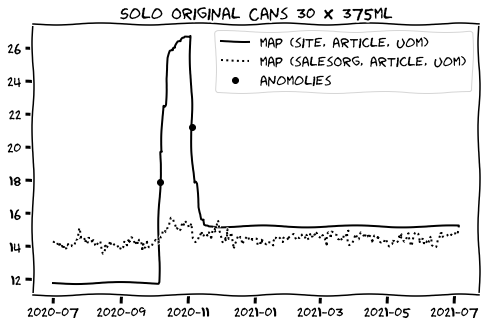

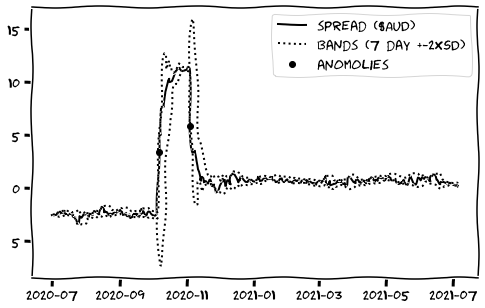

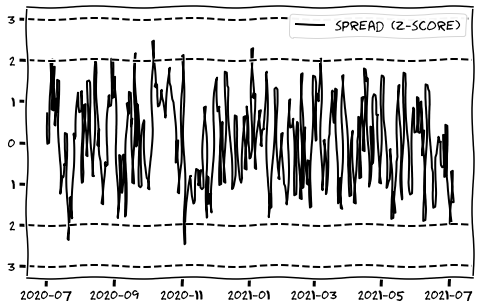

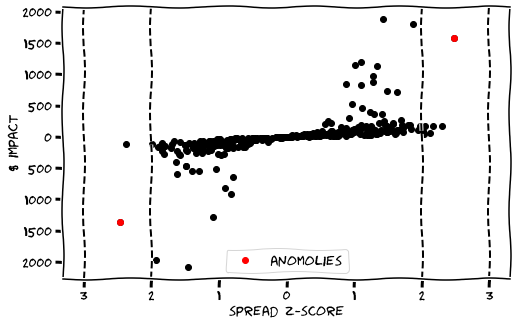

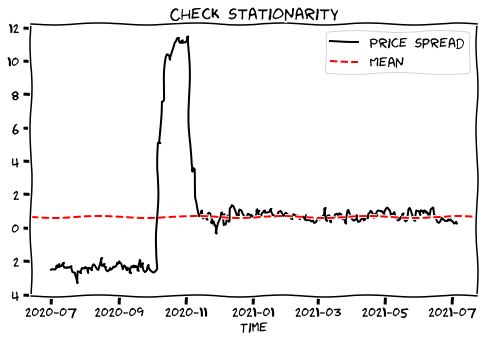

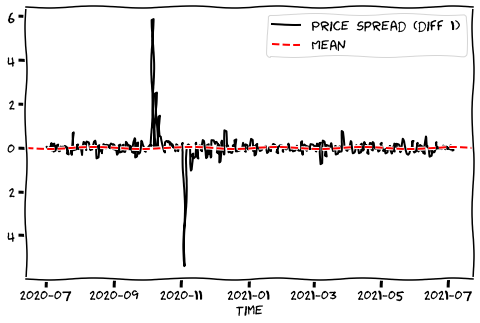

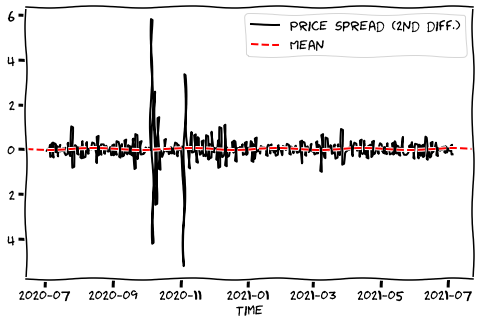

In [80]:
gridPlot_(df,max(df['stock_at_map'].mean()*0.05,1))


We can see from above that approach correctly detects first instance of divergent MAP. Does not duplicate detection.

## Cigs example
Cigs get big price increase once a year - hence why it's a good example to test. Where univariate model detected a sudden move in the articles price and flag suspicious movement... this model, compares with salesorg price movement per article. Although this may detect an anomoly, it may not. But if so this approach uses a more realistic estimate of dollar impact.

In [81]:
dfCig = get_bq_data("""
select *,
(case when abs(spread_z) >=2 then true else false end) as flag_spread_z_outsideBounds
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where site = '1004' and
ltrim(article, '0')='135962'
order by soh_date
""", project_id=project)

dfCig['dollar_impact'] = pd.to_numeric(dfCig['dollar_impact'])
dfCig['spread'] =  pd.to_numeric(dfCig.spread)

Downloading: 100%|██████████| 370/370 [00:01<00:00, 244.68rows/s]


In [82]:
dfCig.head()

,soh_date,soh_date_lag1d,salesorg_id,site,article,ArticleDescription,article_uom,stock_at_map,stock_on_hand,map,Price_Family_Description,stock_at_map_pf_Site,stock_on_hand_pf_Site,map_pf_Site,stock_at_map_pf_SalesOrg,stock_on_hand_pf_SalesOrg,map_pf_SalesOrg,stock_at_map_art_SalesOrg,stock_on_hand_art_SalesOrg,map_art_SalesOrg,spread,spread_ma,spread_std,spread_lower,spread_upper,spread_z,dollar_impact,flag_spread_z_outsideBounds
0,2020-07-01,2020-06-30,1005,1004,135962,Holiday Kings Blue 20pk,EA,1051.000000000,51.000000000,20.607843137,Holiday 20pk,2349.350000000,114.000000000,20.608333333,3030673.020000000,146987.000000000,20.618646683,1392884.600000000,67550.000000000,20.620053294,-0.012210,-0.012210157,NaN,NaN,NaN,NaN,0.000000,False
1,2020-07-02,2020-07-01,1005,1004,135962,Holiday Kings Blue 20pk,EA,824.290000000,40.000000000,20.607250000,Holiday 20pk,1957.760000000,95.000000000,20.608000000,3065266.950000000,148659.000000000,20.619450891,1411322.070000000,68443.000000000,20.620400479,-0.013150,-0.012680318,0.000665,-0.014010,-0.011351,-0.707107,-0.018806,False
2,2020-07-03,2020-07-02,1005,1004,135962,Holiday Kings Blue 20pk,EA,556.360000000,27.000000000,20.605925926,Holiday 20pk,1586.780000000,77.000000000,20.607532468,3242104.940000000,157219.000000000,20.621584796,1501807.720000000,72824.000000000,20.622428320,-0.016502,-0.013954343,0.002256,-0.018467,-0.009442,-1.129351,-0.068797,False
3,2020-07-04,2020-07-03,1005,1004,135962,Holiday Kings Blue 20pk,EA,1463.200000000,71.000000000,20.608450704,Holiday 20pk,2843.990000000,138.000000000,20.608623188,3317161.750000000,160873.000000000,20.619754403,1533997.430000000,74392.000000000,20.620462281,-0.012012,-0.013468652,0.002083,-0.017634,-0.009303,0.699641,0.103452,False
4,2020-07-05,2020-07-04,1005,1004,135962,Holiday Kings Blue 20pk,EA,1360.150000000,66.000000000,20.608333333,Holiday 20pk,2637.890000000,128.000000000,20.608515625,3009728.200000000,145983.000000000,20.616977319,1365987.180000000,66252.000000000,20.618051983,-0.009719,-0.012718651,0.002463,-0.017644,-0.007793,1.218122,0.198000,False


No handles with labels found to put in legend.


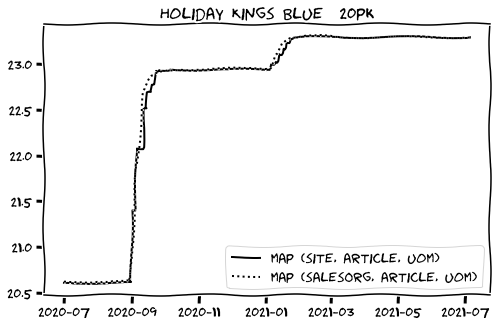

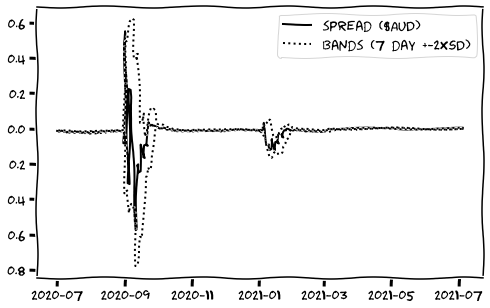

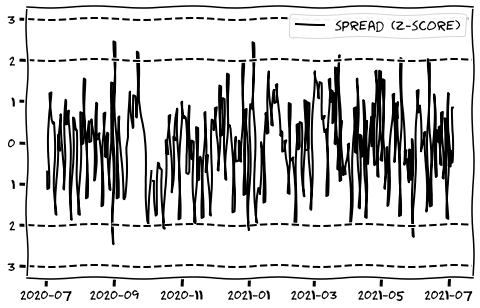

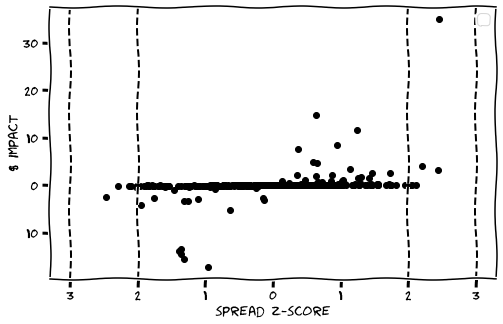

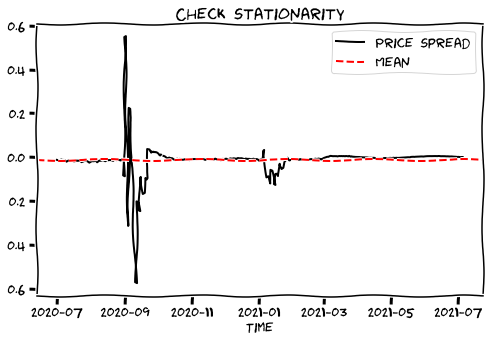

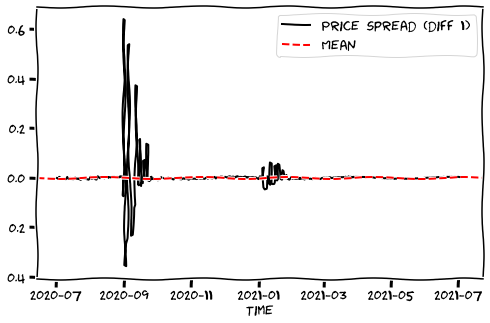

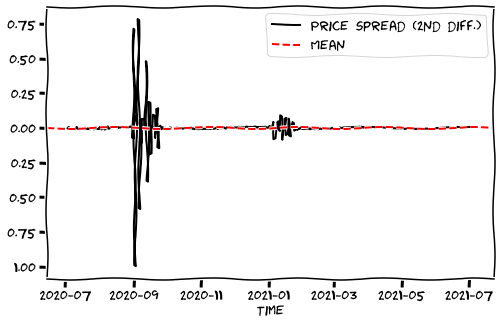

In [83]:
#gridPlot_(dfCig,1)
gridPlot_(dfCig,max(1,dfCig['stock_at_map'].mean()*0.05))

This approach does not flag large map movements when in line with salesorg map movements.

# top down approach
The good news is that per day, site, article, uom data and the above spread + calcs are stored in bigquery.

To show one advantage of this lets take a top-down approach and try to find an article with a big issue on a given day, across many stores.

This can help to pin-point issues that may have material financial impact overall but not at a site level.

In [84]:
# df_highLevel = get_bq_data("""
# SELECT soh_date,	soh_date_lag1d,	salesorg_id,	article,	ArticleDescription,	article_uom,
# sum(stock_on_hand) as sum_stock_on_hand,
# sum(case when abs(spread_z) > 2 then 1 else 0 end) as cnt_anomolies_z_score,
# sum( case when abs(spread_z) > 2 then dollar_impact else 0 end ) as sum_anomoly_dollar_impact,
# (case 
# when sum( case when abs(spread_z) > 2 then stock_on_hand else 0 end ) = 0 then NULL
# when abs(spread_z) > 2 then dollar_impact else 0 end )/sum( case when abs(spread_z) > 2 then stock_on_hand 
# else 0
# end) as sum_anomoly_dollar_impact_per_stock_on_hand
# --sum( case when abs(spread_z) > 2 then dollar_impact else 0 end )/sum( case when abs(spread_z) > 2 then stock_on_hand else 0 end ) as sum_anomoly_dollar_impact_per_stock_on_hand
# FROM `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
# where stock_on_hand != 0
# group by 1,2,3,4,5,6
# having abs(sum_anomoly_dollar_impact)>10000
# order by cnt_anomolies_z_score desc
# limit 1000
# """, project_id=project)

df_highLevel = get_bq_data("""
with dat as (
SELECT soh_date,	soh_date_lag1d,	salesorg_id,	article,	ArticleDescription,	article_uom,
sum(stock_on_hand) as sum_stock_on_hand,
sum(case when abs(spread_z) > 2 then 1 else 0 end) as cnt_anomolies_z_score,
sum( case when abs(spread_z) > 2 then dollar_impact else 0 end ) as sum_anomoly_dollar_impact,
sum( case when abs(spread_z) > 2 then stock_on_hand else 0 end ) as sum_anomoly_stock_on_hand
--sum( case when abs(spread_z) > 2 then dollar_impact else 0 end )/sum( case when abs(spread_z) > 2 then stock_on_hand else 0 end ) as sum_anomoly_dollar_impact_per_stock_on_hand
FROM `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
--where stock_on_hand != 0
group by 1,2,3,4,5,6
having abs(sum_anomoly_dollar_impact)>10000
)
select *,
(case when sum_anomoly_stock_on_hand != 0 then sum_anomoly_dollar_impact/sum_anomoly_stock_on_hand else NULL end ) as sum_anomoly_dollar_impact_per_stock_on_hand
from dat
order by cnt_anomolies_z_score desc
limit 1000
""", project_id=project)


Downloading: 100%|██████████| 920/920 [00:01<00:00, 600.32rows/s]


In [85]:
df_highLevel.head()

,soh_date,soh_date_lag1d,salesorg_id,article,ArticleDescription,article_uom,sum_stock_on_hand,cnt_anomolies_z_score,sum_anomoly_dollar_impact,sum_anomoly_stock_on_hand,sum_anomoly_dollar_impact_per_stock_on_hand
0,2021-04-24,2021-04-23,1005,675287,Bag For Good,EA,1043012.000000000,989,-19881.351617279,1026855.000000000,-0.019361401
1,2020-12-01,2020-11-30,1005,84552,Coca Cola Cans 30x375ml,EA,97596.000000000,987,-14584.053416736,97307.000000000,-0.149876714
2,2021-04-13,2021-04-12,1005,84552,Coca Cola Cans 30x375ml,EA,45469.000000000,986,12745.384325211,45215.000000000,0.281883984
3,2021-03-29,2021-03-28,1005,42605,Coca Cola Drink Cans 24x375ml,EA,109710.000000000,986,-11904.524026708,108607.000000000,-0.109611020
4,2021-04-12,2021-04-11,1005,42605,Coca Cola Drink Cans 24x375ml,EA,84745.000000000,984,11229.707550910,83667.000000000,0.134219077


In [86]:
df_highLevel.query("(cnt_anomolies_z_score>200) & (sum_anomoly_dollar_impact_per_stock_on_hand>1)").sort_values('sum_anomoly_dollar_impact').head()

,soh_date,soh_date_lag1d,salesorg_id,article,ArticleDescription,article_uom,sum_stock_on_hand,cnt_anomolies_z_score,sum_anomoly_dollar_impact,sum_anomoly_stock_on_hand,sum_anomoly_dollar_impact_per_stock_on_hand
111,2020-08-14,2020-08-13,1005,89823,Sesame Seeds 15kg,,30773.495000000,297,10780.810290866,10232.106000000,1.053625743
107,2020-08-22,2020-08-21,1005,829628,Frantelle Spring Water 20X600ml,EA,173.000000000,340,13469.360883331,1489.000000000,9.045910600
94,2021-02-16,2021-02-15,1005,136836,Glade Sense & Spray Refill Ltd Editin12g,EA,4156.000000000,387,14269.316605552,2383.000000000,5.987963326
103,2020-12-28,2020-12-27,1005,793197,WW Coleslaw 400g,EA,7.000000000,346,24603.554325169,376.000000000,65.434984907
26,2020-09-14,2020-09-13,1005,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,279.000000000,941,56075.805100069,14305.000000000,3.920014338


look at Blackmores Glucsmn 1500mg Tab 180pk	(828191).
Find a site with a lot of stock that probelematic day with significant divergence in spread.

In [87]:

blackmoresSOHsummary = get_bq_data("""
select Site,
sum(stock_on_hand) as sum_stock_on_hand,
avg(spread_z) as spread_z,
sum(dollar_impact) as dollar_impact
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where soh_date = '2020-09-14' and
ltrim(article, '0')='828191' and
salesorg_id = '1005' and
abs(spread_z) > 2
group by 1
order by sum_stock_on_hand desc
""", project_id=project)


Downloading: 100%|██████████| 941/941 [00:01<00:00, 682.16rows/s]


In [88]:
blackmoresSOHsummary.head()

,Site,sum_stock_on_hand,spread_z,dollar_impact
0,3969,261.000000000,2.474869,1023.311754612
1,4343,184.000000000,2.474869,721.419852512
2,3304,173.000000000,2.474869,678.287101716
3,5318,123.000000000,2.474869,482.252078538
4,3127,99.000000000,2.474869,388.152734508


In [89]:
blackmoresSOHsummary.tail()

,Site,sum_stock_on_hand,spread_z,dollar_impact
936,1358,1.000000000,2.267785,3.841494552
937,2692,1.000000000,2.473779,3.942226755
938,2894,1.000000000,2.474856,3.912568025
939,3313,1.000000000,2.474869,3.920734692
940,1137,1.000000000,2.267782,3.840654685


In [90]:
dfBigProblem = get_bq_data("""
select *,
(case when abs(spread_z) >=2 then true else false end) as flag_spread_z_outsideBounds
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where site = '3969' and
ltrim(article, '0')='828191'
order by soh_date
""", project_id=project)

dfBigProblem['dollar_impact'] = pd.to_numeric(dfBigProblem['dollar_impact'])
dfBigProblem['spread'] =  pd.to_numeric(dfBigProblem.spread)

Downloading: 100%|██████████| 370/370 [00:01<00:00, 248.92rows/s]


In [91]:
dfBigProblem.head()

,soh_date,soh_date_lag1d,salesorg_id,site,article,ArticleDescription,article_uom,stock_at_map,stock_on_hand,map,Price_Family_Description,stock_at_map_pf_Site,stock_on_hand_pf_Site,map_pf_Site,stock_at_map_pf_SalesOrg,stock_on_hand_pf_SalesOrg,map_pf_SalesOrg,stock_at_map_art_SalesOrg,stock_on_hand_art_SalesOrg,map_art_SalesOrg,spread,spread_ma,spread_std,spread_lower,spread_upper,spread_z,dollar_impact,flag_spread_z_outsideBounds
0,2020-07-01,2020-06-30,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7875.960000000,278.000000000,28.330791367,Blackmores Glucsmn 1500mg Tab 180pk,7875.960000000,278.000000000,28.330791367,341775.870000000,12122.000000000,28.194676621,341775.870000000,12122.000000000,28.194676621,0.136115,0.136114746,NaN,NaN,NaN,NaN,0.000000,False
1,2020-07-02,2020-07-01,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7875.960000000,278.000000000,28.330791367,Blackmores Glucsmn 1500mg Tab 180pk,7875.960000000,278.000000000,28.330791367,325916.140000000,11561.000000000,28.190999049,325916.140000000,11561.000000000,28.190999049,0.139792,0.137953532,0.002600,0.132753,0.143154,0.707107,0.511183,False
2,2020-07-03,2020-07-02,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7875.960000000,278.000000000,28.330791367,Blackmores Glucsmn 1500mg Tab 180pk,7875.960000000,278.000000000,28.330791367,316259.700000000,11219.000000000,28.189651484,316259.700000000,11219.000000000,28.189651484,0.141140,0.139015649,0.002601,0.133814,0.144218,0.816686,0.590537,False
3,2020-07-04,2020-07-03,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7847.630000000,277.000000000,28.330794224,Blackmores Glucsmn 1500mg Tab 180pk,7847.630000000,277.000000000,28.330794224,304489.560000000,10803.000000000,28.185648431,304489.560000000,10803.000000000,28.185648431,0.145146,0.140548185,0.003729,0.133090,0.148006,1.232955,1.273537,False
4,2020-07-05,2020-07-04,1005,3969,828191,Blackmores Glucsmn 1500mg Tab 180pk,EA,7847.630000000,277.000000000,28.330794224,Blackmores Glucsmn 1500mg Tab 180pk,7847.630000000,277.000000000,28.330794224,291331.230000000,10338.000000000,28.180618108,291331.230000000,10338.000000000,28.180618108,0.150176,0.142473771,0.005382,0.131709,0.153238,1.431076,2.133550,False


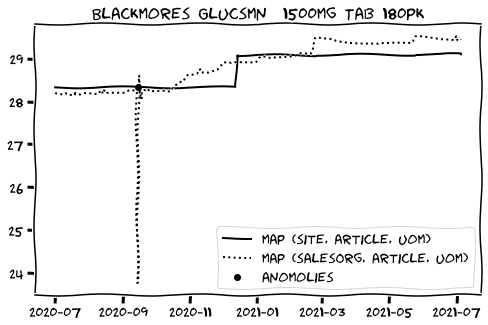

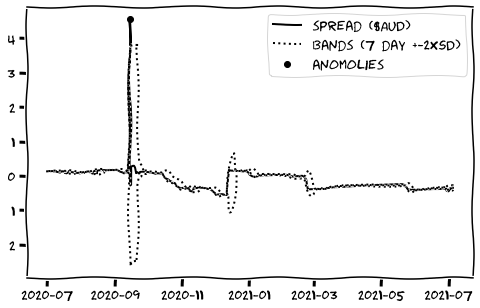

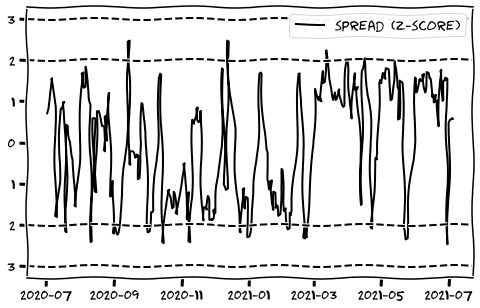

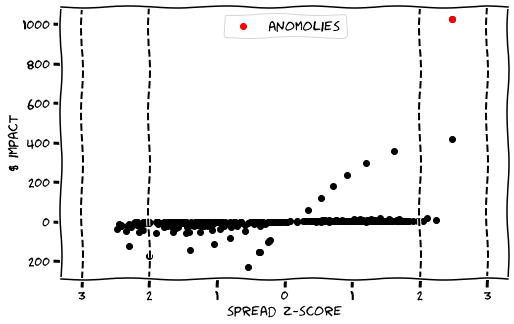

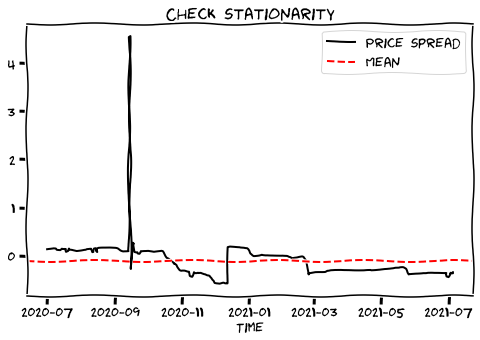

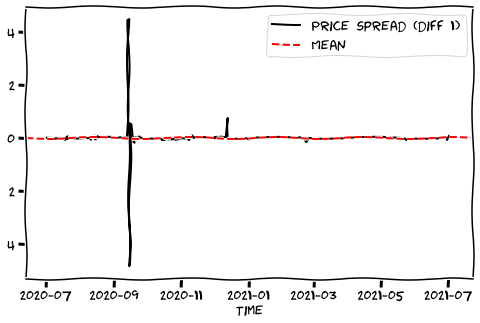

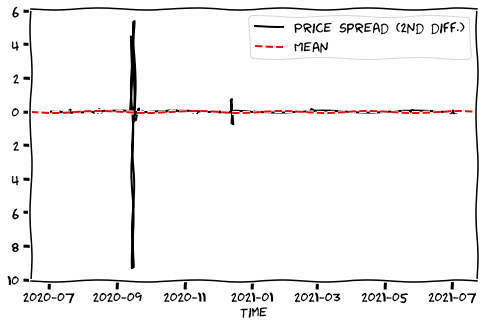

In [92]:
#gridPlot_(dfBigProblem, dollarCutoff=100)
gridPlot_(dfBigProblem, max(1, dfBigProblem['stock_at_map'].mean()*0.05))

This approach flags flat MAP's when pairs spread divergences significatly.

In [93]:
# demonstration of high level summary by article
# lets get a few sites as examples
dfBigProblem_daily = get_bq_data("""
select soh_date, ArticleDescription,
sum(case when abs(spread_z) > 2 then 1 else 0 end) as count_significant_spread_z,
sum(dollar_impact) as dollar_impact
from `gcp-wow-finance-de-lab-dev.017_map.01_mapData`
where salesorg_id = '1005' and
ltrim(article, '0')='828191'
group by 1,2
order by soh_date
""", project_id=project)

dfBigProblem_daily['dollar_impact'] = pd.to_numeric(dfBigProblem_daily['dollar_impact'])

Downloading: 100%|██████████| 370/370 [00:01<00:00, 282.91rows/s]


In [94]:
dfBigProblem_daily.head()

,soh_date,ArticleDescription,count_significant_spread_z,dollar_impact
0,2020-07-01,Blackmores Glucsmn 1500mg Tab 180pk,0,0.000000
1,2020-07-02,Blackmores Glucsmn 1500mg Tab 180pk,0,22.924648
2,2020-07-03,Blackmores Glucsmn 1500mg Tab 180pk,0,24.415754
3,2020-07-04,Blackmores Glucsmn 1500mg Tab 180pk,0,51.671921
4,2020-07-05,Blackmores Glucsmn 1500mg Tab 180pk,0,81.781696


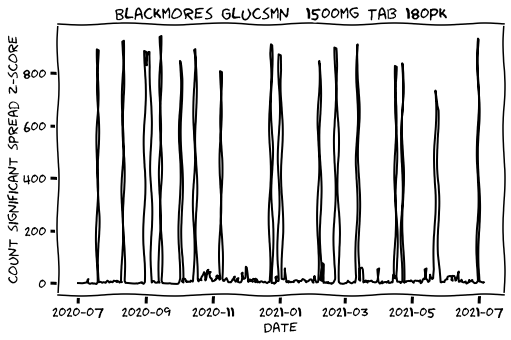

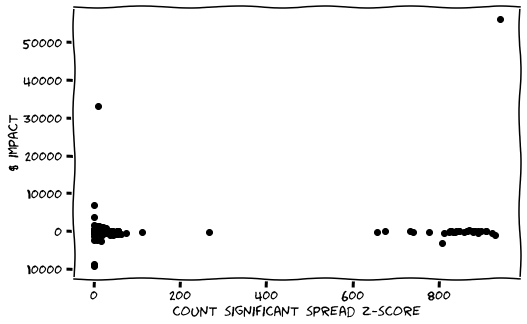

In [95]:
perPlotDim = [8,5]
with plt.xkcd():
    plt.figure(figsize=perPlotDim)
    plt.plot(dfBigProblem_daily.soh_date, dfBigProblem_daily.count_significant_spread_z, '-k', label='map (site, article, uom)')
    plt.xlabel('Date')
    plt.ylabel('count significant spread z-score')
    plt.title(dfBigProblem_daily['ArticleDescription'].iloc[0])


with plt.xkcd():
      plt.figure(figsize=perPlotDim)
      plt.scatter(dfBigProblem_daily.count_significant_spread_z, dfBigProblem_daily.dollar_impact, color='k')
      plt.xlabel('count significant spread z-score')
      plt.ylabel('$ impact')



This top-down approach is helpful. It shows us that this article has an ongoing issue not specific to any one site.

In [96]:
# %%shell
# jupyter nbconvert --to html /content/map_approach.ipynb
